# Overfitting in Random Forests 
## Part 1 - Regression

Dr Jose M Albornoz, May 2019

A Random Forest with only one tree will overfit to data because it is the same as a single decision tree. When we add trees to the Random Forest then the tendency to overfitting should decrease (thanks to bagging and random feature selection). However, the generalization error will not go to zero. The variance of generalization error will approach to zero with more trees added but the bias will not.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import numpy as np
RANDOM_STATE = 801

# 1.- Generate data

We will be using a simple dataset generated from $y = 10 * x + noise$. 

In [2]:
data = np.random.uniform(0, 1,(1000, 1))
noise = np.random.normal(size=(1000,))
X = data[:,:1]
y = 10.0*(data[:,0]) + noise

Text(0, 0.5, 'y (target)')

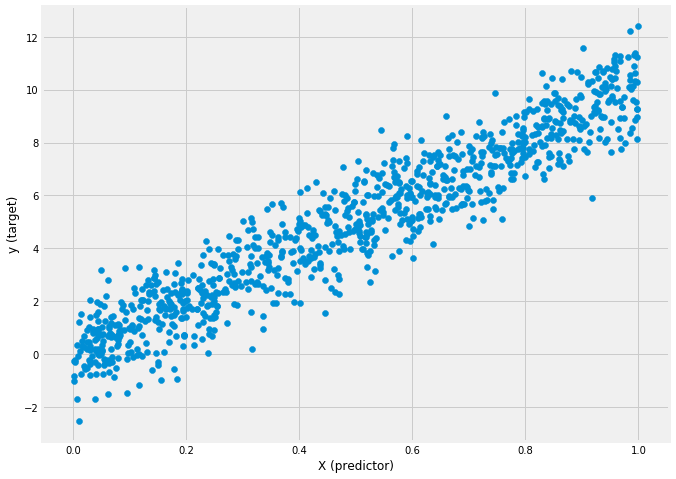

In [3]:
plt.figure(figsize=(10,8))
plt.scatter(X, y)
plt.xlabel("X (predictor)")
plt.ylabel("y (target)")

# 2.- Split into training and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)

# 3.- Random forest model

We will train two models: one with full trees and one with pruning controlled by *min_samples_leaf* hyper-parameter. 

## 3.1.- Full trees random forest

In [5]:
rf = RandomForestRegressor(n_estimators=50)

rf.fit(X_train, y_train)

y_train_predicted = rf.predict(X_train)
y_test_predicted_full_trees = rf.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_predicted)
mse_test = mean_squared_error(y_test, y_test_predicted_full_trees)
print("RF with full trees, Train MSE: {}; Test MSE: {}".format(mse_train, mse_test))

RF with full trees, Train MSE: 0.2109690310607669; Test MSE: 1.4059208298466346


## 3.2.- Pruned trees random forest

In [6]:
rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=25)

rf.fit(X_train, y_train)

y_train_predicted = rf.predict(X_train)
y_test_predicted_pruned_trees = rf.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_predicted)
mse_test = mean_squared_error(y_test, y_test_predicted_pruned_trees)
print("RF with pruned trees, Train MSE: {}; Test MSE: {}".format(mse_train, mse_test))

RF with pruned trees, Train MSE: 0.9240370962878969; Test MSE: 1.016595645714306


We have clear evidence of overfitting - the RF with full trees has a much lower error on train data than the RF with pruned trees but the error on test data is higher.

Text(0, 0.5, 'Pruned random forest prediction')

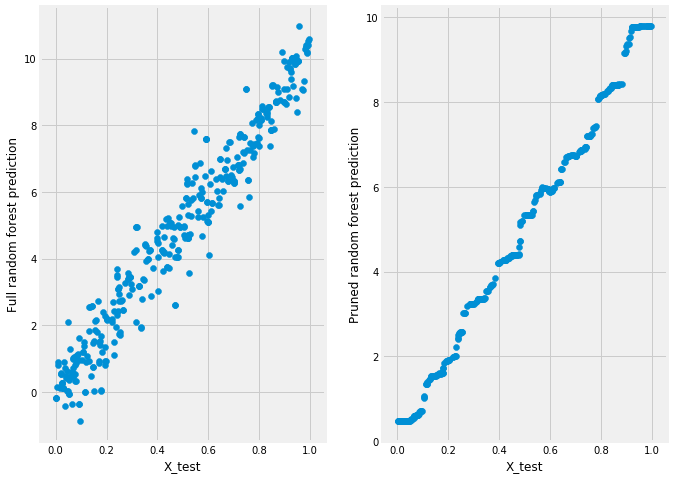

In [7]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.scatter(X_test, y_test_predicted_full_trees)
plt.xlabel("X_test")
plt.ylabel("Full random forest prediction")

plt.subplot(1,2,2)
plt.scatter(X_test, y_test_predicted_pruned_trees)
plt.xlabel("X_test")
plt.ylabel("Pruned random forest prediction")

On the above plot we see how much of the noise is preserved in the response predicted by the full random forest - this noise is being memorised by the model. This is not the case with the pruned trees model, which clearly captures the linear response hidden in the noise - an indication of better generalisation.

# 4.- Overfitting vs number of trees

Let's check how the random forest model will behaves with an increasing number of trees. We will train the RF model starting with 1 tree and add 1 tree in each loop iteration: in every step, we will measure MSE on train and test data.

## 4.1.- Increasing number of trees, full random forest

In [8]:
rf = RandomForestRegressor(n_estimators=1)

n_trees = []
mse_train_full = []
mse_test_full = []

for iter in range(50):

    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    
    mse_train_full.append(mean_squared_error(y_train, y_train_predicted))
    mse_test_full.append(mean_squared_error(y_test, y_test_predicted))
        
    rf.n_estimators += 1
    n_trees.append(rf.n_estimators)

(0, 2)

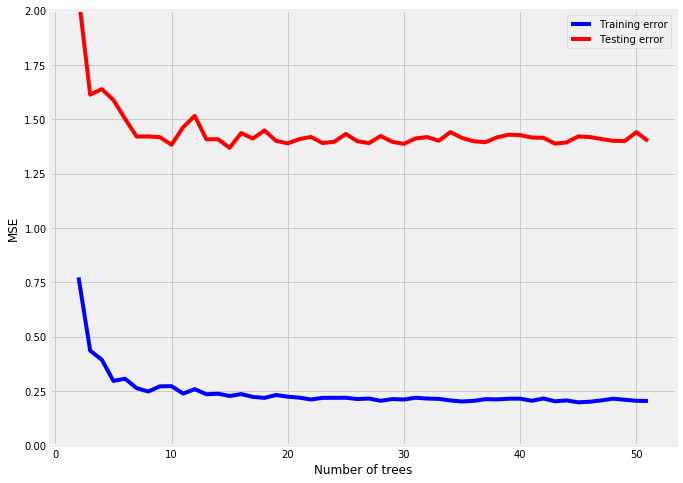

In [9]:
plt.figure(figsize=(10,8))
plt.plot(n_trees, mse_train_full, color='b', label='Training error')
plt.plot(n_trees, mse_test_full, color='r', label='Testing error')
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.ylim(0, 2)

## 4.2.- Increasing number of trees, pruned random forest

In [10]:
rf = RandomForestRegressor(n_estimators=1, min_samples_leaf=25)

n_trees = []
mse_train_pruned = []
mse_test_pruned = []

for iter in range(50):

    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    
    mse_train_pruned.append(mean_squared_error(y_train, y_train_predicted))
    mse_test_pruned.append(mean_squared_error(y_test, y_test_predicted))
        
    rf.n_estimators += 1
    n_trees.append(rf.n_estimators)

(0, 2)

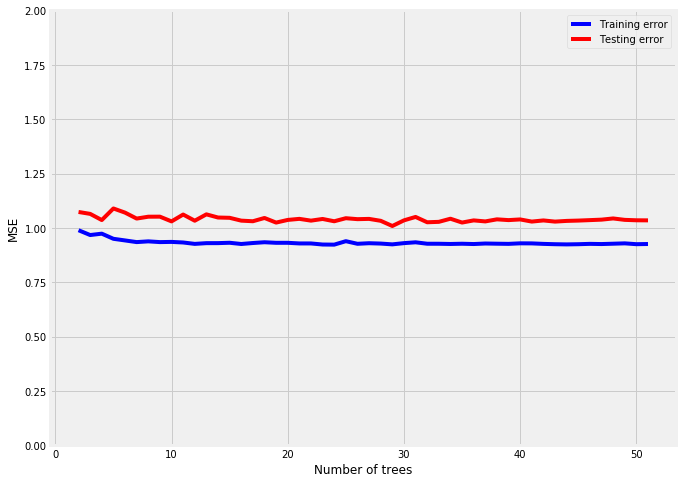

In [11]:
plt.figure(figsize=(10,8))
plt.plot(n_trees, mse_train_pruned, color='b', label='Training error')
plt.plot(n_trees, mse_test_pruned, color='r', label='Testing error')
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.ylim(0, 2)

We can see how using a random forest with full trees clearly overfits the data, as evidenced by the difference between training and test MSEs. The pruning of the tree helps us control this overfit.

# 5.- Controlling Random Forest overfitting through grid search and cross-validation

We will now see how grid search and crossvalidation can be used to find an optimal random forest model.

In [12]:
n_trees = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
max_depth = [5, 10, 15, 20, 25, 30]
min_samples_leaf = [10, 15, 20, 25, 30, 35, 40, 45, 50]
param_grid = [{'n_estimators': n_trees, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}]

In [13]:
rf = RandomForestRegressor()
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

In [14]:
gs = gs.fit(X_train, y_train)

In [15]:
print(gs.best_score_)

-1.0423714282080108


In [16]:
print(gs.best_params_)

{'max_depth': 30, 'min_samples_leaf': 20, 'n_estimators': 25}


In [17]:
reg = gs.best_estimator_

In [18]:
reg.fit(X_test, y_test)
print('Test mse: %.3f' % reg.score(X_test, y_test))

Test mse: 0.918


We see how the grid search produced an optimal combination of parameters that resulted in a model with good generalisation.

In [19]:
print('Train mse: %.3f' % mean_squared_error(y_train, reg.predict(X_train)))
print('Test mse: %.3f' % mean_squared_error(y_test, reg.predict(X_test)))

Train mse: 1.052
Test mse: 0.853
